In [116]:
# !pip install imageio
# !pip install imageio\[ffmpeg\]

import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
from IPython.display import clear_output
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (24,9)


In [137]:
def create_grid(L, max_stack_size):
    return np.random.randint(low=0, high=max_stack_size, size=(L, L), dtype=np.uint32)

def step(grid, max_stack_size):
    L = len(grid)

    y = random.randint(0, L - 1)
    x = random.randint(0, L - 1)
    position = (y, x)

    grid[position] += 1

    avalanche_size = 0
    avalanche_time = 0

    # chaos begins
    if grid[position] == max_stack_size:
        grid[position] = 0
        # todo neighbourhood should be a function that's passed in based on max_stack_size
        queue = neighbourhood(position, L)
        new_queue = []
        while len(queue) > 0:
            avalanche_size += len(queue)
            avalanche_time += 1
            for (ny, nx) in queue:
                grid[(ny, nx)] += 1
                if grid[(ny, nx)] == 4:
                    new_queue.extend(neighbourhood((ny, nx), L))
                    grid[(ny, nx)] = 0

            queue = new_queue
            new_queue = []

    return avalanche_time, avalanche_size


def neighbourhood(position, L):
    cy, cx = position
    neigh = []
    for (dy, dx) in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ny, nx = cy + dy, cx + dx
        if 0 <= nx < L and 0 <= ny < L:
            neigh.append((ny, nx))

    return neigh

def to_frame(grid, max_stack_size):
    frame = (np.copy(grid) / max_stack_size * 255).astype(np.uint8)
    return frame


def frames_to_gif(output_name, frames):
    with imageio.get_writer(output_name, mode='I', fps=60) as writer:
        for i, frame in enumerate(frames):
            # todo this should happen based on some condition passed in.
            if i > 49000:
                writer.append_data(frame)


def simulation(grid_size = 48, max_time = int(5e5),
               max_stack_size=4, output='l2.gif',
               create_gif=False,
               draw_plot=True):
    grid = create_grid(grid_size, max_stack_size)
    frames = [to_frame(grid, max_stack_size)]
    avalanche_times, avalanche_sizes = [], []
    for t in range(max_time):
        avalanche_time, avalanche_size = step(grid, max_stack_size)
        avalanche_times.append(avalanche_time)
        avalanche_sizes.append(avalanche_size)

        frames.append(to_frame(grid, max_stack_size))

        clear_output(wait=True)
        print(f't: {t}, avalanche_time: {avalanche_time}, avalanche_size: {avalanche_size}')

    if create_gif:
        frames_to_gif(output, frames)
        print(f'created a gif: {output}')

    if draw_plot:
        x = np.arange(0, max_time, 1, dtype=np.uint32)
        y = np.asarray(avalanche_sizes, dtype=np.uint32)
        y2 = np.asarray(avalanche_times, dtype=np.uint32)

        fig, ax = plt.subplots()
        ax.plot(x, y, marker='o')
        ax.plot(x, y2, marker='o')
        ax.set_title('Avalanche Sizes/Durations in each iteration.')

    return avalanche_sizes


def simulation_series(
        grid_size=48,
        no_simulations=5,
        max_time=int(1e2)):

    max_avalanche_size = grid_size * grid_size * 50
    xs = np.arange(0, max_avalanche_size, 1, dtype=np.uint32)
    ys = np.zeros(shape=(max_avalanche_size,), dtype=np.uint32)
    for simulation_i in range(no_simulations):
        avalanche_sizes = simulation(grid_size=grid_size, max_time=max_time, draw_plot=False)
        for avalanche_size in avalanche_sizes:
            ys[avalanche_size] += 1

    def draw_power_law(xs, ys):
        fig, ax = plt.subplots()
        xs = xs[1:]
        ys = ys[1:]
        idx = np.nonzero(ys)

        x = xs[idx]
        y = ys[idx]

        ax.loglog(x, y, marker='o', label='avalanches')
        ax.set_title('Power')

        def power_law(x, a, b):
            return a * np.power(x, b)

        popt, pcov = curve_fit(power_law, x, y)
        ax.plot(x, power_law(x, *popt), label=f'power law: y = {popt[0]:.4f} * x ^ ({popt[1]:.4f})')
        ax.legend()

    draw_power_law(xs, ys)


t: 999, avalanche_time: 0, avalanche_size: 0
[37.82538638 -0.52577145]


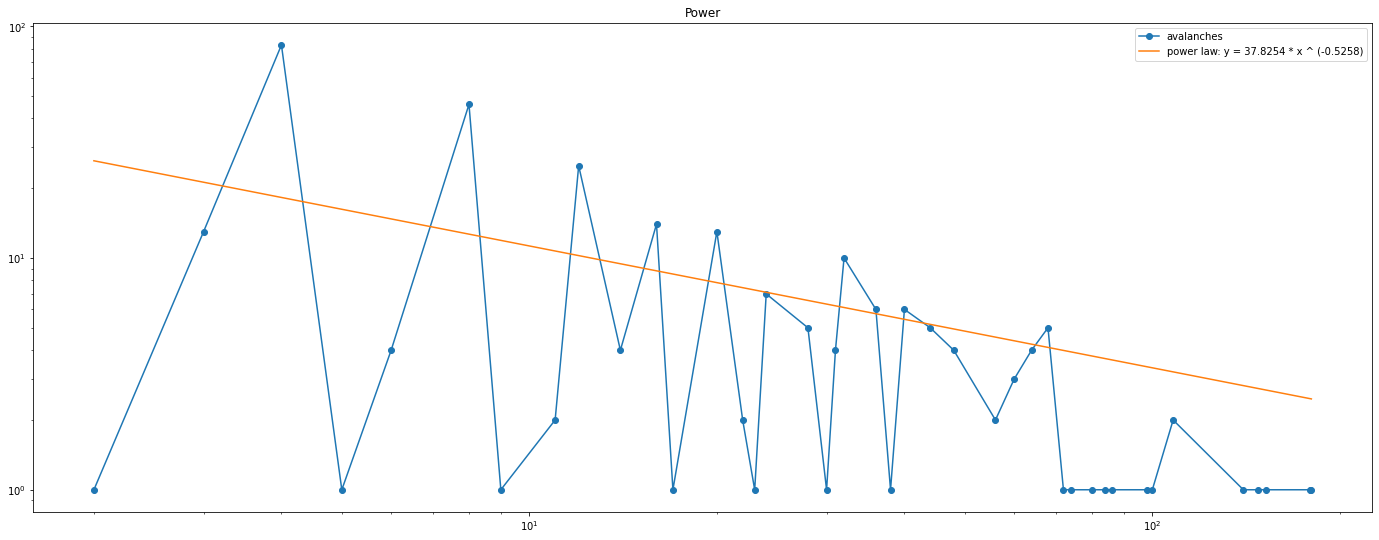

In [138]:

simulation_series(no_simulations=1, max_time=int(1e3))
